<a href="https://colab.research.google.com/github/hanggao811/AnomalyDetectionLIGO/blob/main/CNN_Autoencoder_newdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
# Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Input
from matplotlib import pyplot as plt
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
import glob, re
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.models import load_model as keras_load_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.signal import welch, csd, coherence, stft
# Set random seed
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [107]:
# Mount to googlecolab
from google.colab import drive
drive.mount('/content/drive')

# train with Argyro's dataset
os.chdir('/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/new_dataset')
# Load data and normalize it
background = np.load('O3_Background_dataset.npz')

background_train = background['data'][:-1024]
stds = np.std(background_train, axis=-1)[:, :, np.newaxis]
background_train_normed = background_train/stds
background_train = np.swapaxes(background_train, 1, 2)
background_train_normed = np.swapaxes(background_train_normed, 1, 2)

background_test = background['data'][-1024:]
stds = np.std(background_test, axis=-1)[:, :, np.newaxis]
background_test_normed = background_test/stds
background_test = np.swapaxes(background_test, 1, 2)
background_test_normed = np.swapaxes(background_test_normed, 1, 2)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
os.chdir('/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/new_dataset')

snr=3

# load"SineGaussian","BBH","Cusp","Kink","KinkKink","WhiteNoiseBurst"
WNB = np.load('O3_WhiteNoiseBurst_biased_low.npz')['data']
index = np.where(np.load('O3_WhiteNoiseBurst_biased_low.npz')['snr']>snr)[0]
WNB = WNB[index]
stds = np.std(WNB, axis=-1)[:, :, np.newaxis]
WNB_normed = WNB/stds
WNB = np.swapaxes(WNB, 1, 2)
WNB_normed = np.swapaxes(WNB_normed, 1, 2)

KinkKink = np.load('O3_KinkKink_biased_low.npz')['data']
index = np.where(np.load('O3_KinkKink_biased_low.npz')['snr']>snr)[0]
KinkKink = KinkKink[index]
stds = np.std(KinkKink, axis=-1)[:, :, np.newaxis]
KinkKink_normed = KinkKink/stds
KinkKink = np.swapaxes(KinkKink, 1, 2)
KinkKink_normed = np.swapaxes(KinkKink_normed, 1, 2)

Kink = np.load('O3_Kink_biased_low.npz')['data']
index = np.where(np.load('O3_Kink_biased_low.npz')['snr']>snr)[0]
Kink = Kink[index]
stds = np.std(Kink, axis=-1)[:, :, np.newaxis]
Kink_normed = Kink/stds
Kink = np.swapaxes(Kink, 1, 2)
Kink_normed = np.swapaxes(Kink_normed, 1, 2)

SG = np.load('O3_SineGaussian_biased_low.npz')['data']
index = np.where(np.load('O3_SineGaussian_biased_low.npz')['snr']>snr)[0]
SG = SG[index]
stds = np.std(SG, axis=-1)[:, :, np.newaxis]
SG_normed = SG/stds
SG = np.swapaxes(SG, 1, 2)
SG_normed = np.swapaxes(SG_normed, 1, 2)

Cusp = np.load('O3_Cusp_biased_low.npz')['data']
index = np.where(np.load('O3_Cusp_biased_low.npz')['snr']>snr)[0]
Cusp = Cusp[index]
stds = np.std(Cusp, axis=-1)[:, :, np.newaxis]
Cusp_normed = Cusp/stds
Cusp = np.swapaxes(Cusp, 1, 2)
Cusp_normed = np.swapaxes(Cusp_normed, 1, 2)

BBH = np.load('O3_BBH_biased_low.npz')['data']
index = np.where(np.load('O3_BBH_biased_low.npz')['snr']>snr)[0]
BBH = BBH[index]
stds = np.std(BBH, axis=-1)[:, :, np.newaxis]
BBH_normed = BBH/stds
BBH = np.swapaxes(BBH, 1, 2)
BBH_normed = np.swapaxes(BBH_normed, 1, 2)

print('shape for background train/test' , background_train.shape, background_test.shape)
print('shape for SG ' , SG.shape)
print('shape for BBH ' , BBH.shape)
print('shape for Cusp ' , Cusp.shape)
print('shape for Kink ' , Kink.shape)
print('shape for KinkKink ' , KinkKink.shape)
print('shape for WNB ' , WNB.shape)

shape for background train/test (254976, 200, 2) (1024, 200, 2)
shape for SG  (1000, 200, 2)
shape for BBH  (1000, 200, 2)
shape for Cusp  (1000, 200, 2)
shape for Kink  (1000, 200, 2)
shape for KinkKink  (1000, 200, 2)
shape for WNB  (1000, 200, 2)


In [109]:
# Making correlation
def add_correlation_channel(x):
    x1, x2 = x[:, :, 0], x[:, :, 1]
    corr = np.array([
        np.correlate(x1[i], x2[i], mode='same') for i in range(x.shape[0])
    ])
    return np.stack([x1, x2, corr], axis=-1)

background_train = add_correlation_channel(background_train)
background_test = add_correlation_channel(background_test)
SG = add_correlation_channel(SG)
BBH = add_correlation_channel(BBH)
Cusp = add_correlation_channel(Cusp)
Kink = add_correlation_channel(Kink)
KinkKink = add_correlation_channel(KinkKink)
WNB = add_correlation_channel(WNB)

background_train_normed = add_correlation_channel(background_train_normed)
background_test_normed = add_correlation_channel(background_test_normed)
SG_normed = add_correlation_channel(SG_normed)
BBH_normed = add_correlation_channel(BBH_normed)
Cusp_normed = add_correlation_channel(Cusp_normed)
Kink_normed = add_correlation_channel(Kink_normed)
KinkKink_normed = add_correlation_channel(KinkKink_normed)
WNB_normed = add_correlation_channel(WNB_normed)

SOLUTION GIVEN

In [110]:
tf.config.experimental.enable_op_determinism()

class Autoencoder:
    def __init__(self, input_shape=(200, 3), stft_shape=(6, 41), dropout=0.1, batch_size=256, epochs=50, lr=1e-3,
             f1=3, f2=16, f3=32, f4=64, f5=32, f6=16, f7=3,
             k1=16, k2=32, k3=64, k4=128, k5=64, k6=32, k7=16,
             s1=2, s2=2, s3=1, s4=1, s5=1, s6=2, s7=2):
        super().__init__()
        # Architecture settings
        self.input_shape = input_shape
        self.stft_shape = stft_shape
        self.dropout = dropout
        # Training settings
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        # Filter sizes
        self.f1, self.f2, self.f3 = f1, f2, f3
        self.f4, self.f5, self.f6, self.f7 = f4, f5, f6, f7
        # Kernel sizes
        self.k1, self.k2, self.k3 = k1, k2, k3
        self.k4, self.k5, self.k6, self.k7 = k4, k5, k6, k7
        # Strides
        self.s1, self.s2, self.s3 = s1, s2, s3
        self.s4, self.s5, self.s6, self.s7 = s4, s5, s6, s7
        self.model_ = None

    def positional_encoding(self, inputs):
        embed_size = inputs.shape[-1]
        input_length = inputs.shape[-2]
        assert embed_size % 2 == 0, 'embed_size must be even'
        p, i = np.meshgrid(np.arange(input_length), np.arange(embed_size // 2))
        pos_emb = np.empty((1,input_length, embed_size))
        pos_emb[0,:,::2] = np.sin(p/(10000**(2*i/embed_size))).T
        pos_emb[0,:,1::2] = np.cos(p/(10000**(2*i/embed_size))).T
        self.pos_encoding = tf.constant(pos_emb.astype(np.float32))
        return inputs + self.pos_encoding[:, :input_length, :]

    def build_model(self):
        inputs = keras.Input(shape=self.input_shape)
        x = inputs

        # Encoder
        print('Encoder layer shape')
        x = layers.Conv1D(filters=self.f1, kernel_size=self.k1, strides=self.s1, padding="same")(x)
        print(x.shape)
        x = layers.Dropout(rate=self.dropout)(x)
        x = layers.Conv1D(filters=self.f2, kernel_size=self.k2, strides=self.s2, padding="same")(x)
        print(x.shape)
        x = layers.Conv1D(filters=self.f3, kernel_size=self.k3, strides=self.s3, padding="same")(x)
        print(x.shape)

        # Bottleneck
        print("Bottleneck shape")
        latent_x = layers.Conv1D(filters=self.f4, kernel_size=self.k4, strides=self.s4, padding="same")(x)
        print(latent_x.shape)
        x = layers.Dropout(rate=self.dropout)(latent_x)

        # Decoder Head
        print("Decoder layer shape")
        x = layers.Conv1DTranspose(filters=self.f5, kernel_size=self.k5, strides=self.s5, padding="same")(x)
        print(x.shape)
        x = layers.Conv1DTranspose(filters=self.f6, kernel_size=self.k6, strides=self.s6, padding="same")(x)
        print(x.shape)
        decoder_output = layers.Conv1DTranspose(filters=self.f7, kernel_size=self.k7, strides=self.s7, padding="same")(x)
        print(decoder_output.shape)

        self.model_ = keras.Model(inputs=inputs, outputs=decoder_output)
        self.model_.compile(loss='mse',
                            optimizer=keras.optimizers.Adam(learning_rate=self.lr))


    def predict(self, X):
        return self.model_.predict(X, batch_size=self.batch_size)


In [111]:
# without normalization and epoch wise
def warmup_clr_scheduler(epoch):
    initial_lr = 1e-5     # Start small
    base_lr = 1e-5        # Bottom of CLR
    max_lr = 1e-3         # Peak of CLR
    step_size = 22        # Half-cycle length
    warmup_epochs = 5     # Warm-up length

    if epoch < warmup_epochs:
        # Linear warm-up
        return initial_lr + (base_lr - initial_lr) * (epoch / warmup_epochs)
    else:
        # Cyclical Learning Rate (triangular)
        cycle_epoch = epoch - warmup_epochs
        cycle = np.floor(1 + cycle_epoch / (2 * step_size))
        x = np.abs(cycle_epoch / step_size - 2 * cycle + 1)
        return base_lr + (max_lr - base_lr) * max(0, (1 - x))

clr_callback = LearningRateScheduler(warmup_clr_scheduler, verbose=1)

param_set = [{'batch_size': 700, 'dropout': 0, 'epochs': 79, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.00001, 's1': 1, 's2': 2, 's3':2, 's4':1},
             {'batch_size': 700, 'dropout': 0.1, 'epochs': 50, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.001, 's1': 1, 's2': 2, 's3':2, 's4':1}, #0.7596,0.7789,0.7684
             {'batch_size':700,'dropout':0.1,'epochs':50,'f1':8,'f2':16,'f3':32,'f4':128,'f5':32,'f6':16,'f7':3,'k1':2,'k2':4,'k3':6,'k4':8,'k5':4,'k6':3,'k7':2,'lr':0.001,'s1':2,'s2':2,'s3':1,'s4':2,'s5':2,'s6':2,'s7':2}, #0.7788
             {'batch_size':1000,'dropout':0.1,'epochs':50,'f1':8,'f2':16,'f3':32,'f4':128,'f5':32,'f6':16,'f7':3,'k1':2,'k2':4,'k3':6,'k4':8,'k5':4,'k6':3,'k7':2,'lr':0.001,'s1':2,'s2':2,'s3':1,'s4':2,'s5':2,'s6':2,'s7':2}, #0.7797
             {'batch_size':700,'dropout':0,'epochs':50,'f1':8,'f2':16,'f3':32,'f4':128,'f5':32,'f6':16,'f7':3,'k1':2,'k2':4,'k3':6,'k4':8,'k5':4,'k6':3,'k7':2,'lr':0.001,'s1':2,'s2':2,'s3':1,'s4':2,'s5':2,'s6':2,'s7':2}, #0.7784
             {'batch_size':256,'dropout':0.05,'epochs':50,'f1':8,'f2':16,'f3':32,'f4':128,'f5':32,'f6':16,'f7':3,'k1':2,'k2':4,'k3':6,'k4':8,'k5':4,'k6':3,'k7':2,'lr':0.001,'s1':2,'s2':2,'s3':1,'s4':2,'s5':2,'s6':2,'s7':2}, #0.7829
             {'batch_size':256,'dropout':0.1,'epochs':50,'f1':8,'f2':16,'f3':32,'f4':128,'f5':32,'f6':16,'f7':3,'k1':2,'k2':4,'k3':6,'k4':8,'k5':4,'k6':3,'k7':2,'lr':0.001,'s1':2,'s2':2,'s3':1,'s4':2,'s5':2,'s6':2,'s7':2}, #0.7831
             {'batch_size':128,'dropout':0.1,'epochs':50,'f1':8,'f2':16,'f3':32,'f4':128,'f5':32,'f6':16,'f7':3,'k1':2,'k2':4,'k3':6,'k4':8,'k5':4,'k6':3,'k7':2,'lr':0.001,'s1':2,'s2':2,'s3':1,'s4':2,'s5':2,'s6':2,'s7':2}, #0.7804
             {'batch_size':128,'dropout':0.1,'epochs':50,'f1':8,'f2':16,'f3':32,'f4':16,'f5':32,'f6':16,'f7':3,'k1':2,'k2':4,'k3':6,'k4':8,'k5':4,'k6':3,'k7':2,'lr':0.001,'s1':2,'s2':2,'s3':1,'s4':2,'s5':2,'s6':2,'s7':2}, #0.7833
             {'batch_size':128,'dropout':0.1,'epochs':50,'f1':8,'f2':16,'f3':32,'f4':16,'f5':32,'f6':16,'f7':3,'k1':3,'k2':5,'k3':16,'k4':32,'k5':4,'k6':3,'k7':2,'lr':0.001,'s1':2,'s2':2,'s3':1,'s4':2,'s5':2,'s6':2,'s7':2}, #0.7860 #(relu)0.7925 #(celu)0.7918 #(noactivation)0.7949
             {'batch_size':128,'dropout':0,'epochs':50,'f1':8,'f2':16,'f3':32,'f4':16,'f5':32,'f6':16,'f7':3,'k1':3,'k2':5,'k3':16,'k4':32,'k5':4,'k6':3,'k7':2,'lr':0.001,'s1':2,'s2':2,'s3':1,'s4':2,'s5':2,'s6':2,'s7':2}, #0.7305
             {'batch_size':128,'dropout':0.2,'epochs':50,'f1':8,'f2':16,'f3':32,'f4':16,'f5':32,'f6':16,'f7':3,'k1':3,'k2':5,'k3':16,'k4':32,'k5':4,'k6':3,'k7':2,'lr':0.001,'s1':2,'s2':2,'s3':1,'s4':2,'s5':2,'s6':2,'s7':2}, #0.7913
             {'batch_size':128,'dropout':0.2,'epochs':50,'f1':8,'f2':16,'f3':32,'f4':8,'f5':32,'f6':16,'f7':3,'k1':3,'k2':5,'k3':16,'k4':32,'k5':4,'k6':3,'k7':2,'lr':0.001,'s1':2,'s2':2,'s3':1,'s4':2,'s5':2,'s6':2,'s7':2}, #0.7824
             {'batch_size':64,'dropout':0.2,'epochs':50,'f1':8,'f2':16,'f3':32,'f4':4,'f5':32,'f6':16,'f7':3,'k1':3,'k2':5,'k3':16,'k4':32,'k5':4,'k6':3,'k7':2,'lr':0.001,'s1':2,'s2':2,'s3':1,'s4':2,'s5':2,'s6':2,'s7':2}, #0.7555
             {'batch_size':64,'dropout':0.1,'epochs':50,'f1':8,'f2':16,'f3':32,'f4':4,'f5':32,'f6':16,'f7':3,'k1':3,'k2':5,'k3':16,'k4':32,'k5':4,'k6':3,'k7':2,'lr':0.001,'s1':2,'s2':2,'s3':1,'s4':2,'s5':2,'s6':2,'s7':2}, #0.7598

             ]
params = param_set[-6]
param_str = '_'.join([f'{k}-{v}' for k, v in params.items()])
filepath = f"/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save/model_{param_str}_epoch-{{epoch:02d}}.keras"
checkpoint = ModelCheckpoint(
    filepath=filepath,
    save_freq='epoch',
    save_weights_only=False,
    verbose=1
)
AE = Autoencoder(input_shape=(200, 3), **params)
AE.build_model()
AE.model_.fit(background_train,background_train,epochs=AE.epochs,batch_size=AE.batch_size,validation_split=0.2,verbose=1,callbacks=[clr_callback,checkpoint])

Encoder layer shape
(None, 100, 8)
(None, 50, 16)
(None, 50, 32)
Bottleneck shape
(None, 25, 16)
Decoder layer shape
(None, 50, 32)
(None, 100, 16)
(None, 200, 3)

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/50
1591/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 53.2921
Epoch 1: saving model to /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save/model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-01.keras
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 53.2714 - val_loss: 30.2966 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/50
1592/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 28.2298
Epoch 2: saving model to /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save/model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1

In [112]:
def getfpr_tpr(model, bg_mse, anomaly):
    anomaly_pred = model.predict(anomaly)
    anomaly_mse = np.mean((anomaly_pred - anomaly)**2, axis=(1,2))
    true_val = np.concatenate((np.zeros(bg_mse.shape[0]),np.ones(anomaly_mse.shape[0])))
    pred_val = np.concatenate((bg_mse, anomaly_mse))
    fpr, tpr, thresholds = roc_curve(true_val, pred_val)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, thresholds, auc_score

def eval(model, bg, bbh, sg, wnb, kink, cusp, kinkkink):
    bg_pred = model.predict(bg)
    bg_mse = np.mean((bg_pred - bg)**2, axis=(1,2))

    bbh_fpr, bbh_tpr, bbh_thresholds, bbh_auc = getfpr_tpr(model, bg_mse, bbh)
    sg_fpr, sg_tpr, sg_thresholds, sg_auc = getfpr_tpr(model, bg_mse, sg)
    wnb_fpr, wnb_tpr, wnb_thresholds, wnb_auc = getfpr_tpr(model, bg_mse, wnb)
    kink_fpr, kink_tpr, kink_thresholds, kink_auc = getfpr_tpr(model, bg_mse, kink)
    cusp_fpr, cusp_tpr, cusp_thresholds, cusp_auc = getfpr_tpr(model, bg_mse, cusp)
    kinkkink_fpr, kinkkink_tpr, kinkkink_thresholds, kinkkink_auc = getfpr_tpr(model, bg_mse, kinkkink)

    plt.figure(figsize=(10, 7))
    plt.plot(bbh_fpr, bbh_tpr,label=f'bbh_AUC = {bbh_auc:.3f}')
    plt.plot(sg_fpr, sg_tpr,label=f'sg_AUC = {sg_auc:.3f}')
    plt.plot(wnb_fpr, wnb_tpr,label=f'wnb_AUC = {wnb_auc:.3f}')
    plt.plot(kink_fpr, kink_tpr,label=f'kink_AUC = {kink_auc:.3f}')
    plt.plot(cusp_fpr, cusp_tpr,label=f'cusp_AUC = {cusp_auc:.3f}')
    plt.plot(kinkkink_fpr, kinkkink_tpr,label=f'kinkkink_AUC = {kinkkink_auc:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
    plt.title(f'snr >{snr}')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.legend()
    plt.show()

    return bbh_auc, sg_auc, wnb_auc, kink_auc, cusp_auc, kinkkink_auc

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


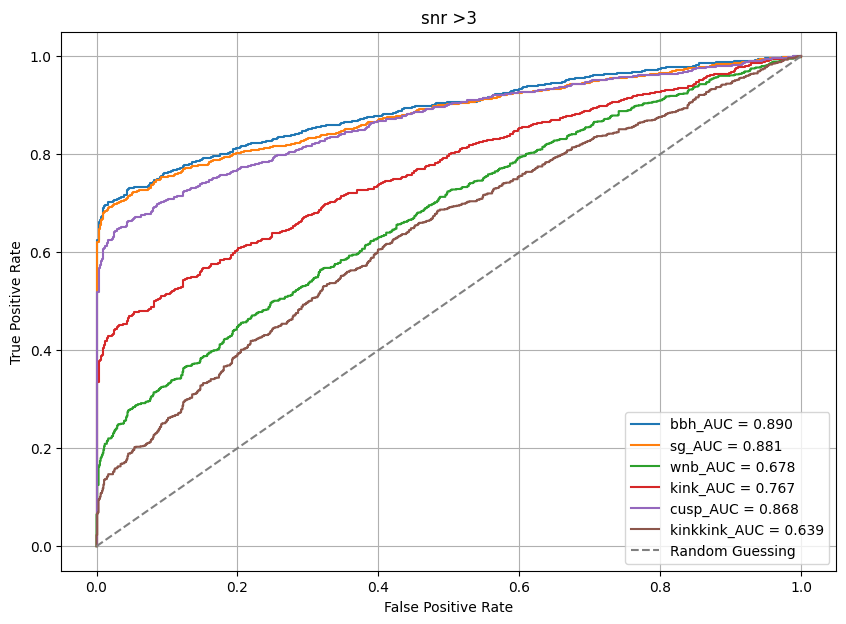

(np.float64(0.8899765625),
 np.float64(0.8813330078125),
 np.float64(0.67815185546875),
 np.float64(0.7668164062499999),
 np.float64(0.8678623046875),
 np.float64(0.6394819335937499))

In [113]:
eval(AE, background_test, BBH, SG, WNB, Kink, Cusp, KinkKink)


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-01.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


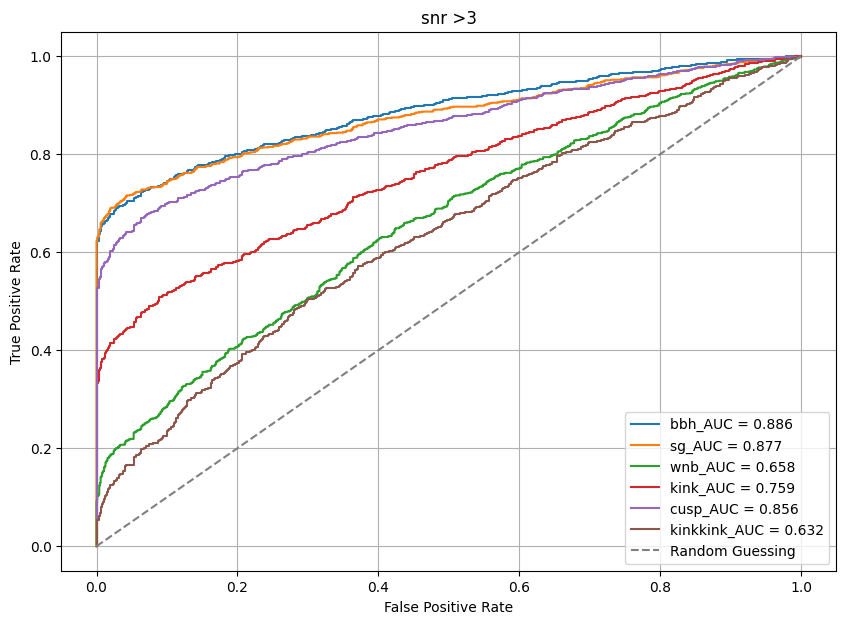


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-02.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


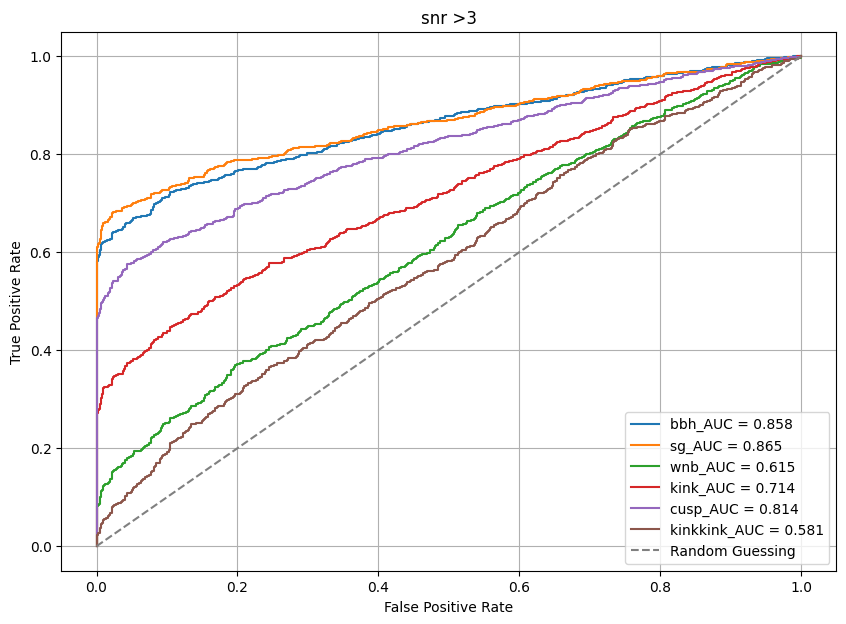


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-03.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


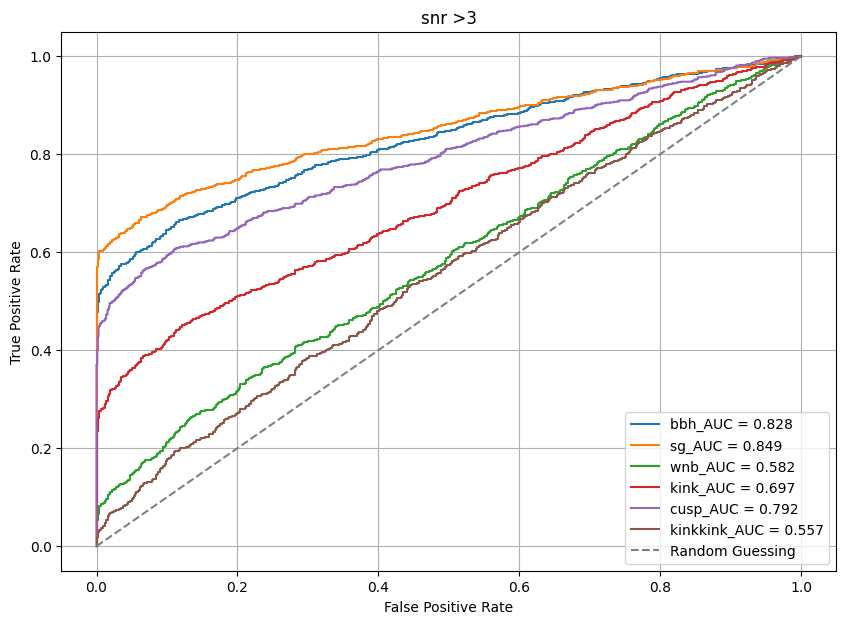


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-04.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


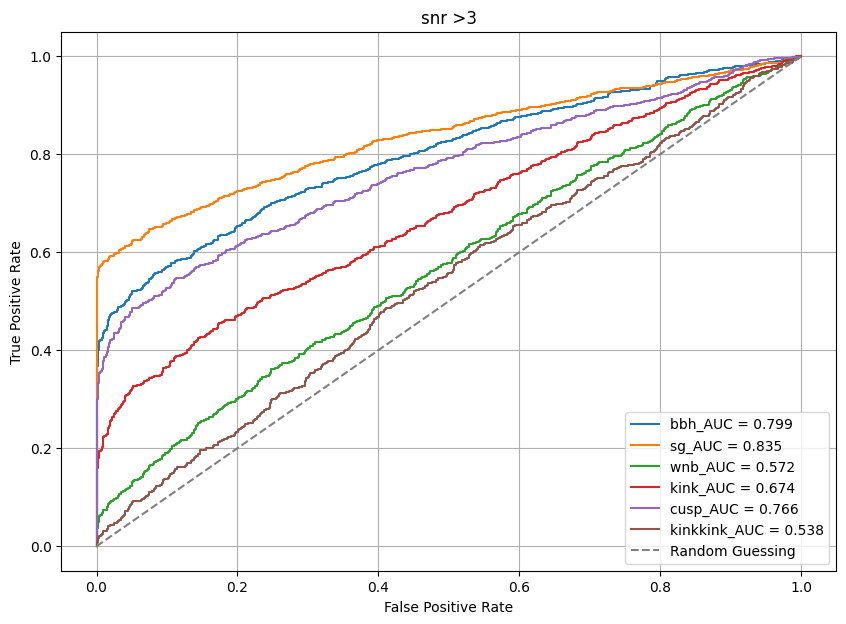


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-05.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


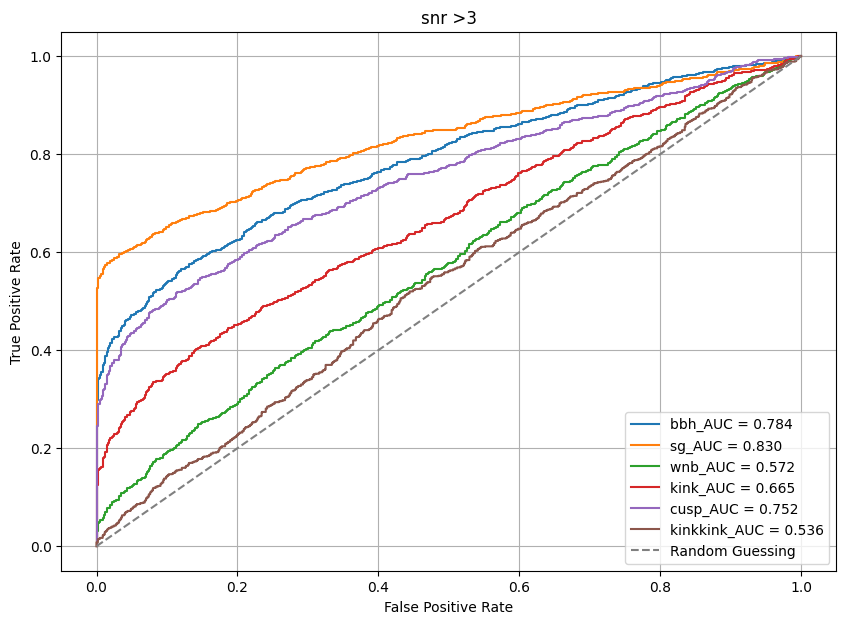


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-06.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


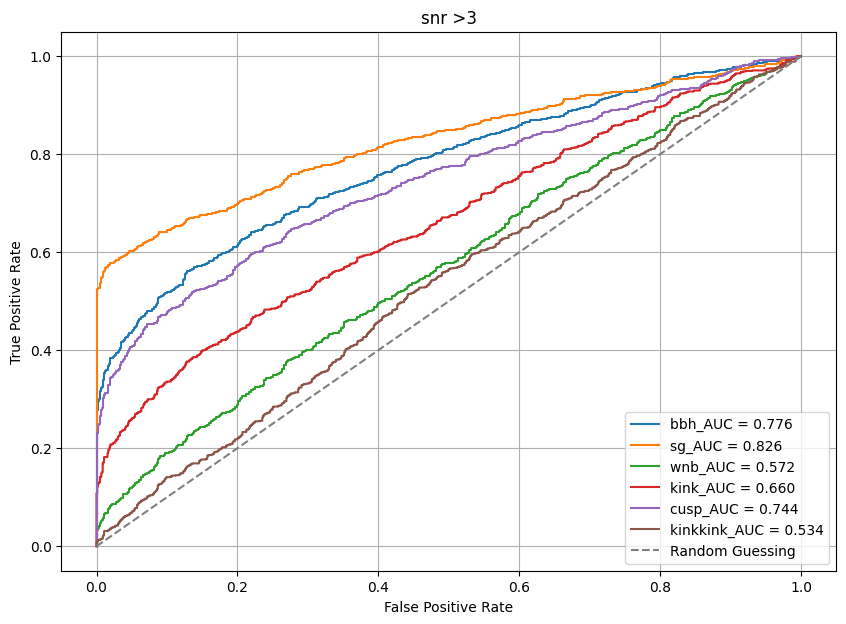


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-07.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


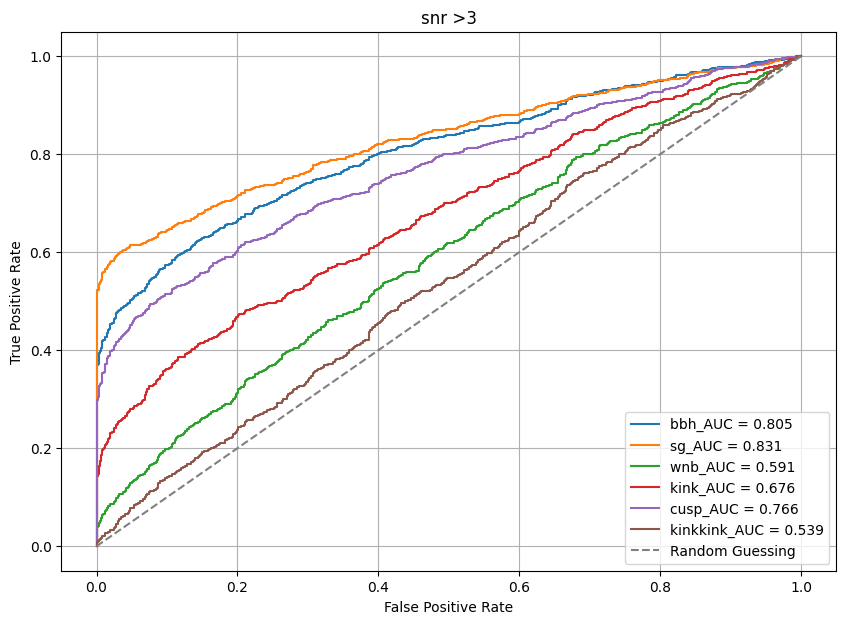


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-08.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


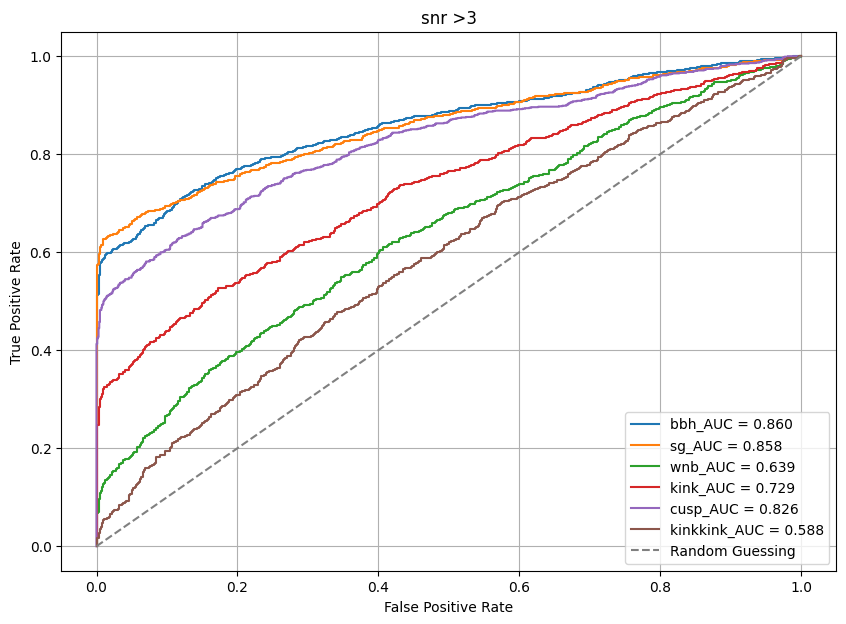


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-09.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


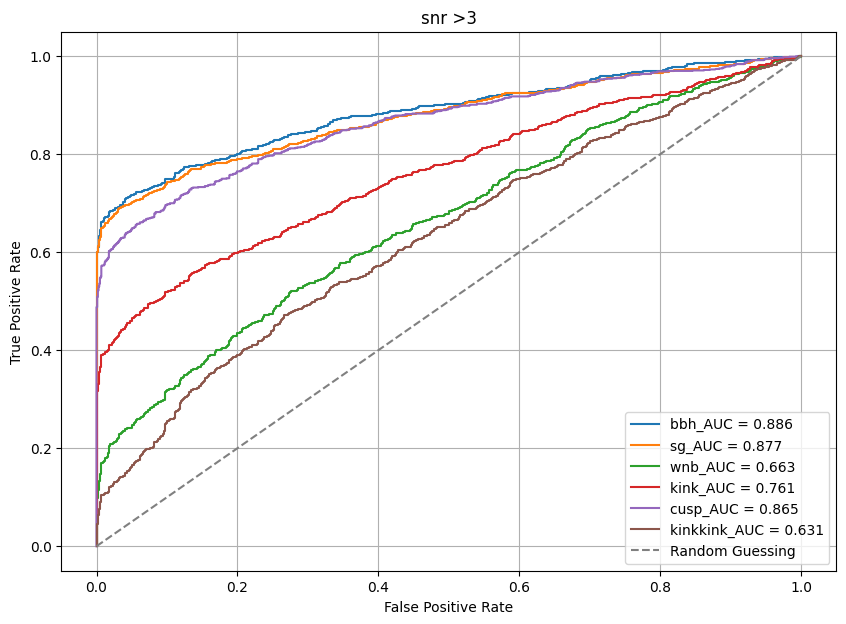


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-10.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


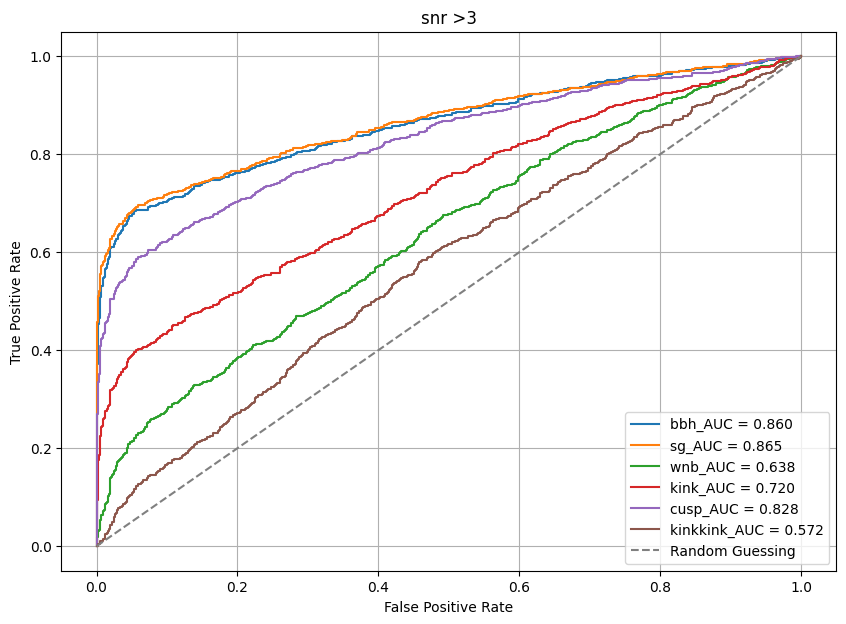


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-11.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


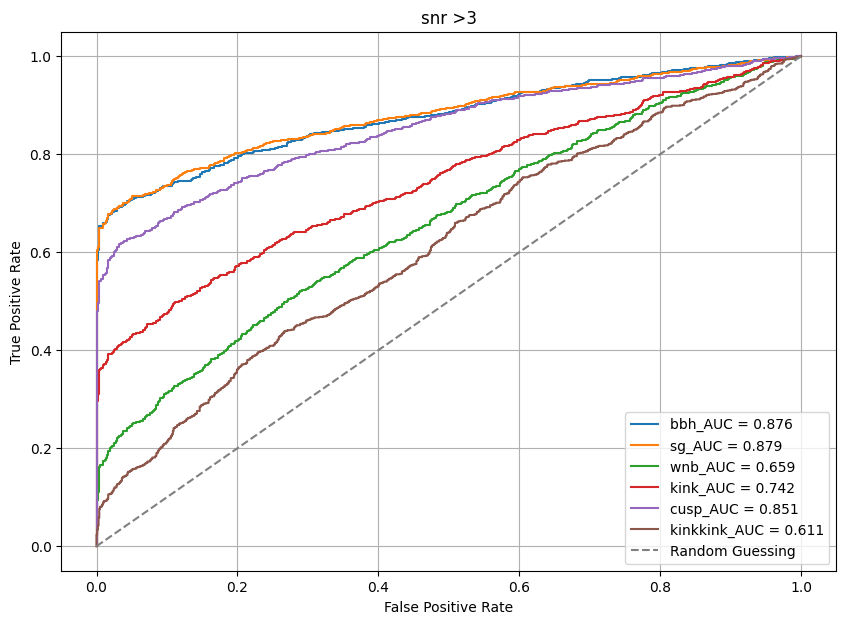


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-12.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


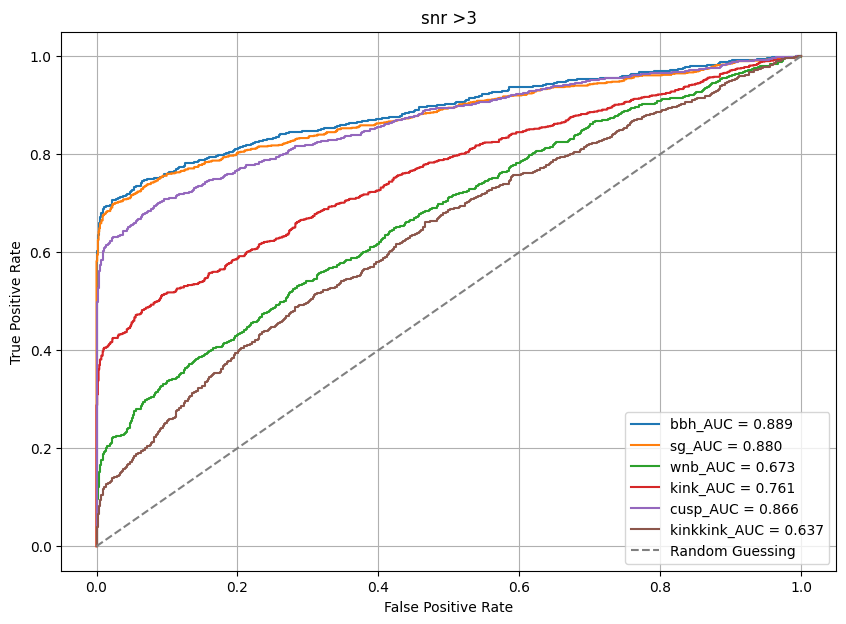


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-13.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


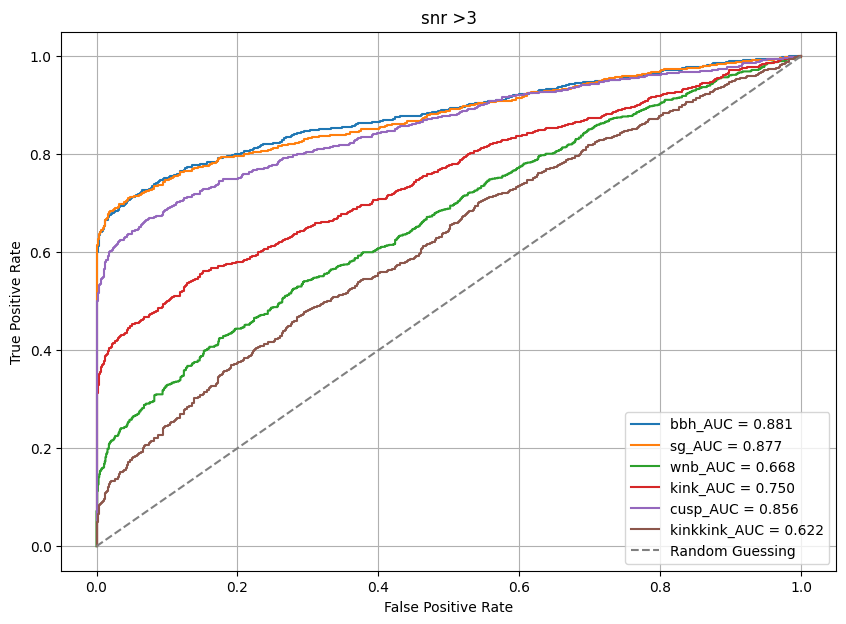


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-14.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


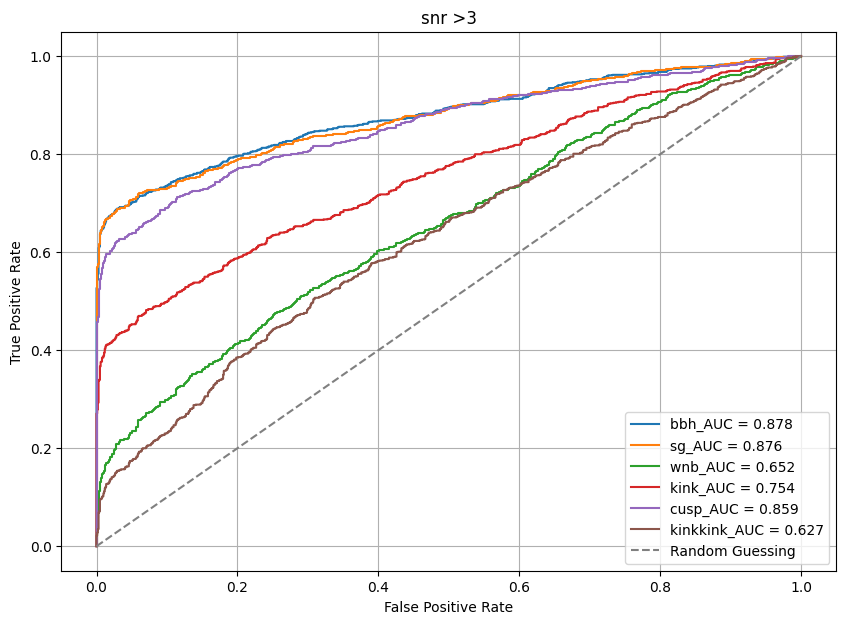


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-15.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


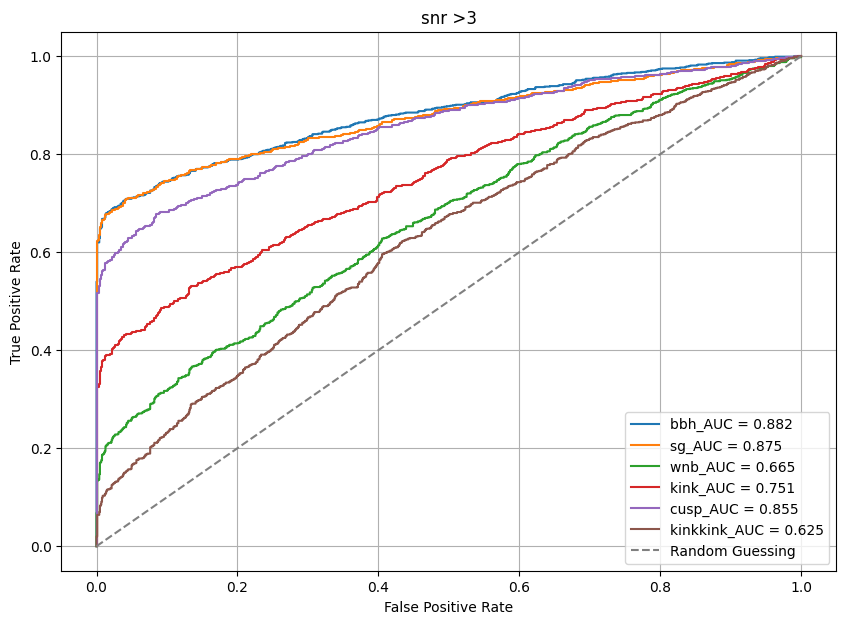


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-16.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


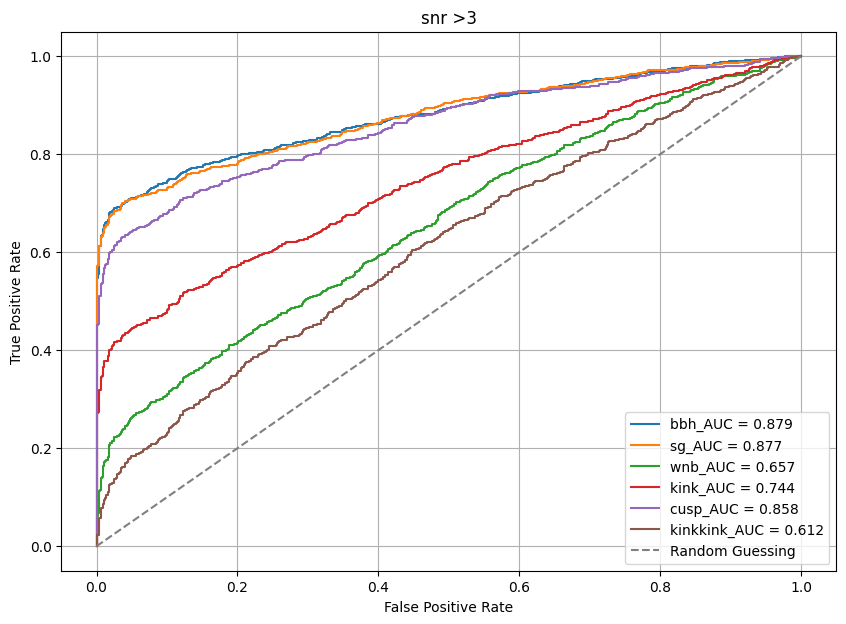


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-17.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


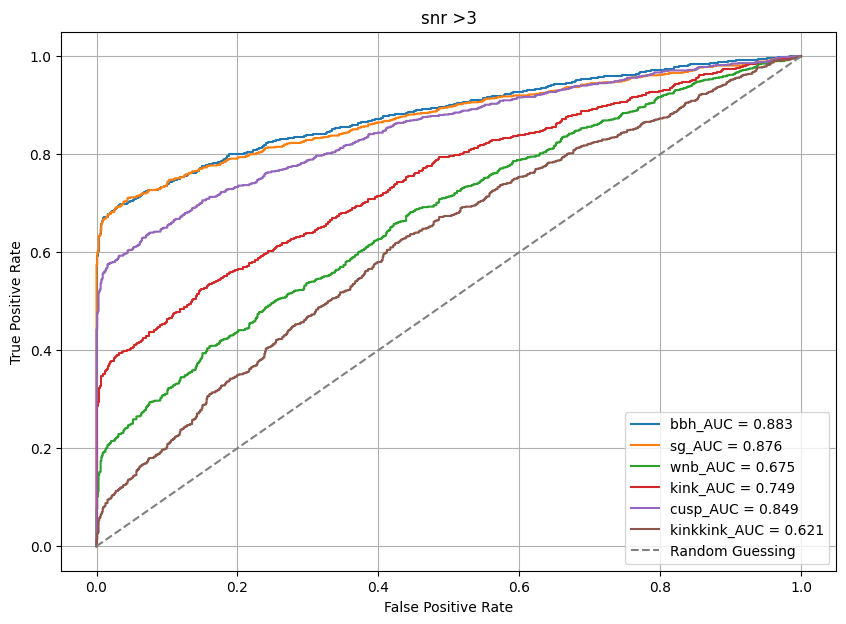


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-18.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


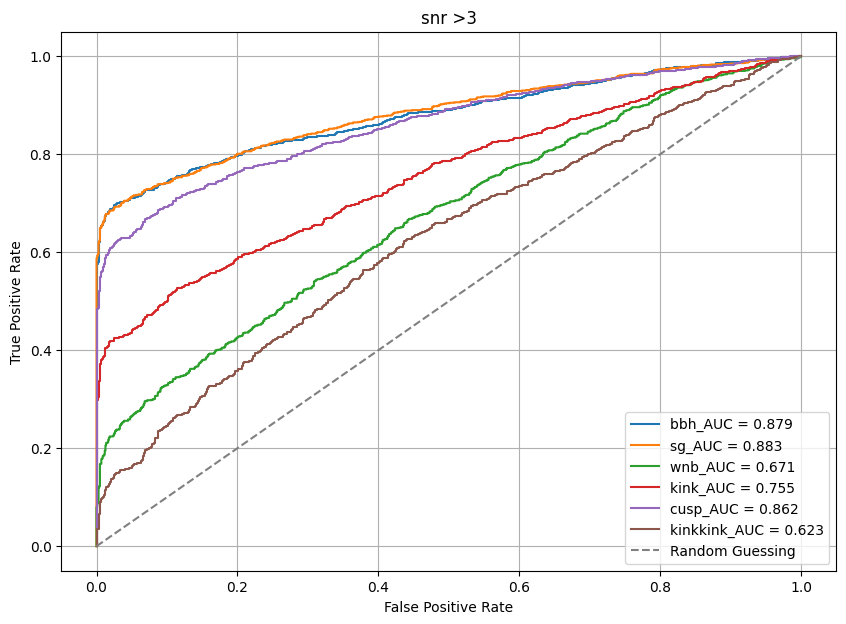


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-19.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


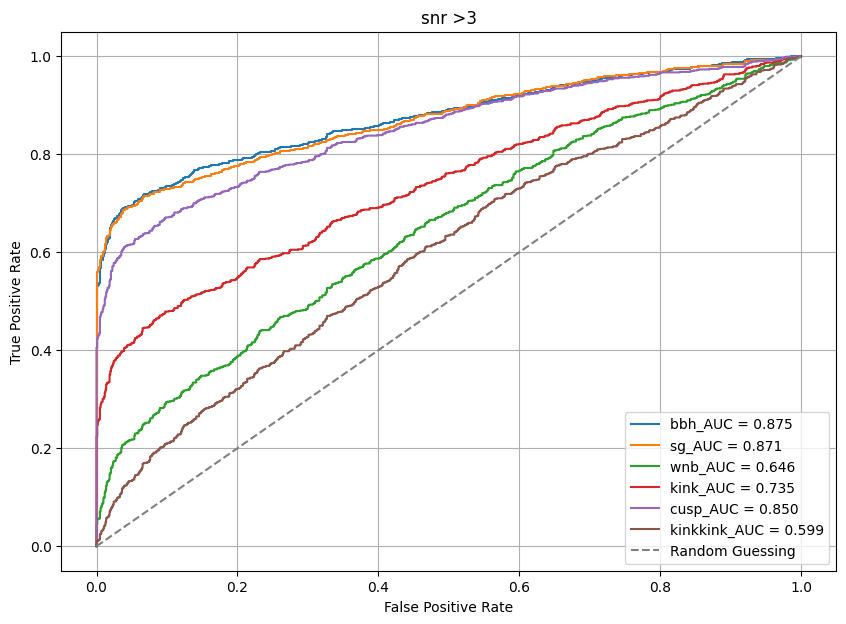


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-20.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


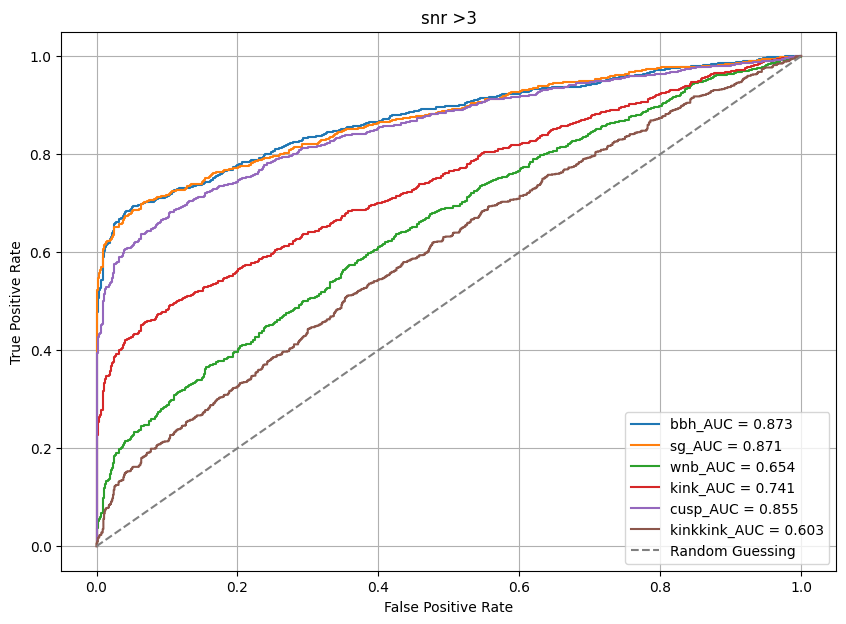


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-21.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


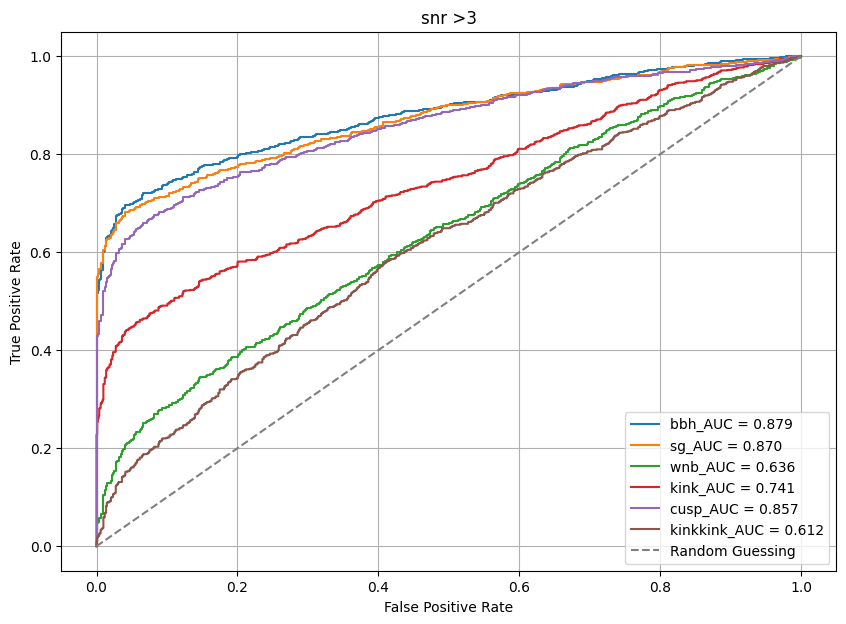


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-22.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


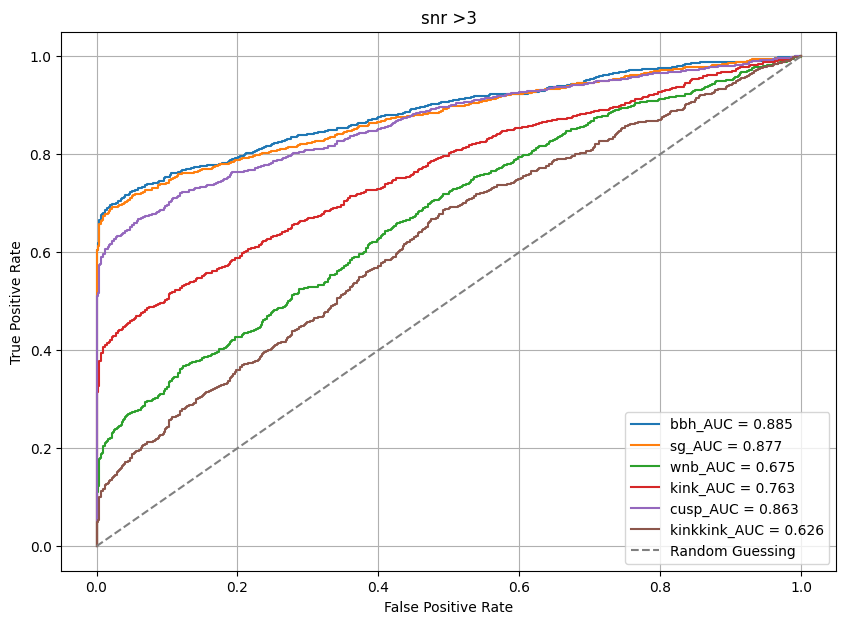


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-23.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


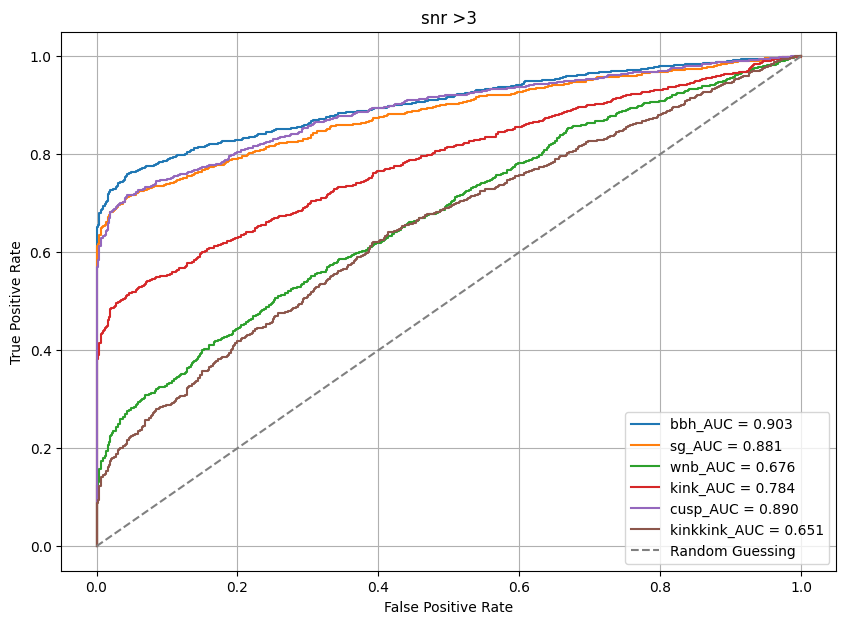


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-24.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


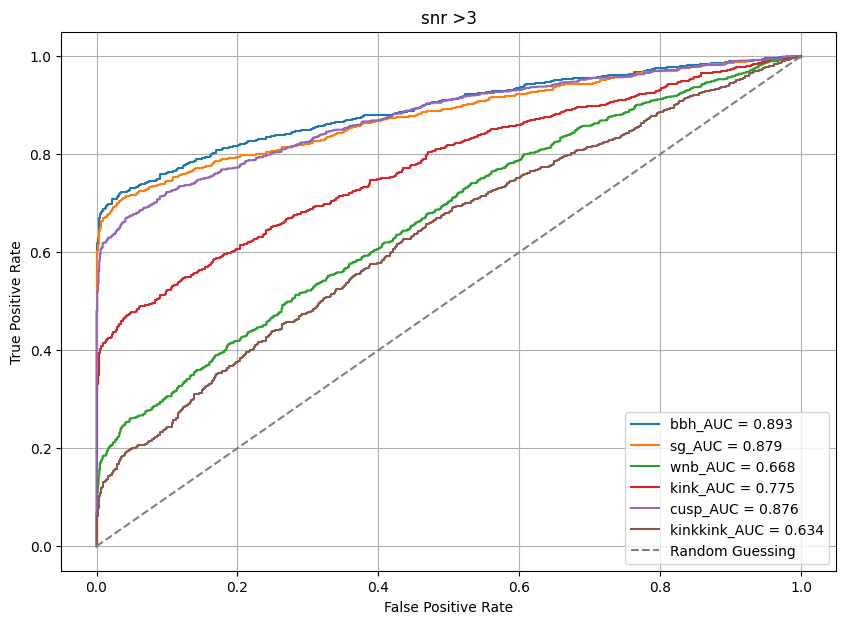


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-25.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


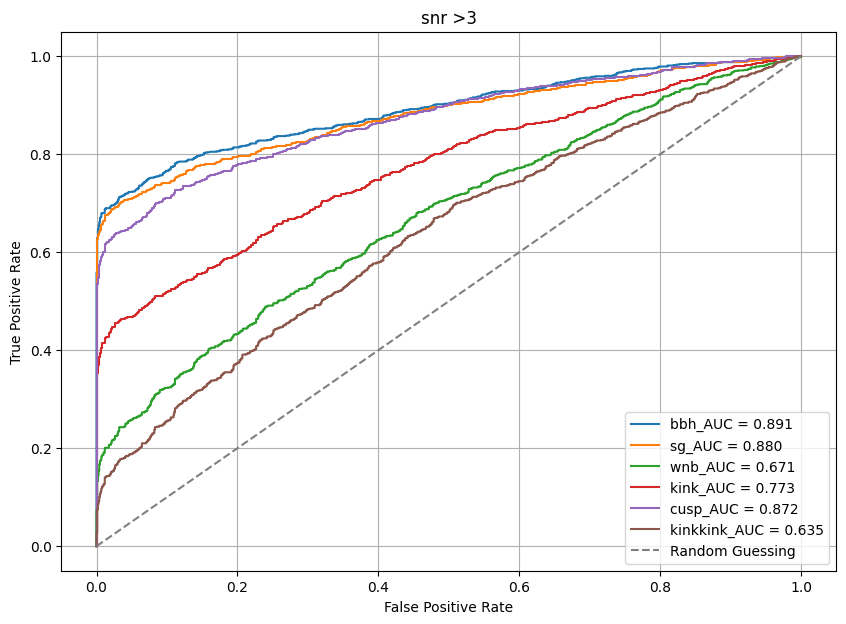


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-26.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


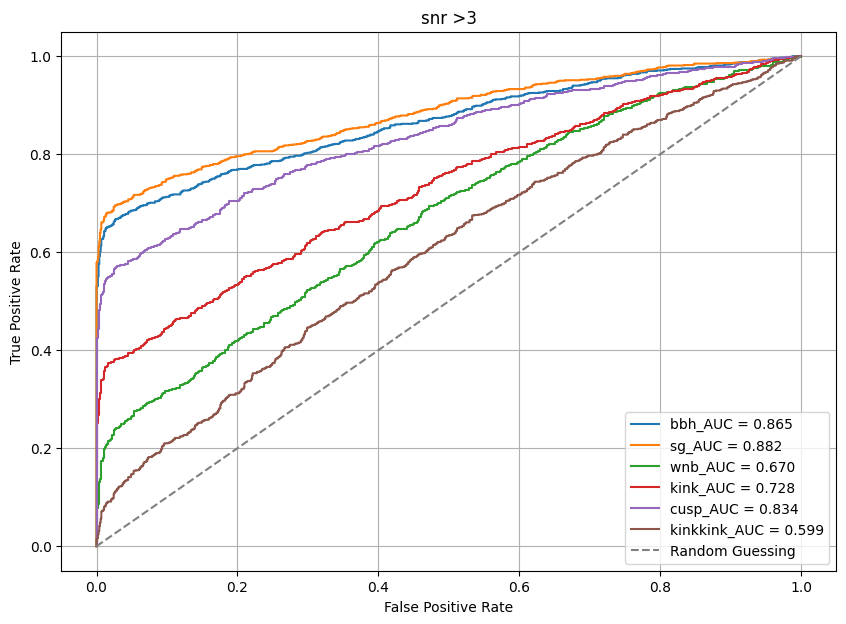


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-27.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


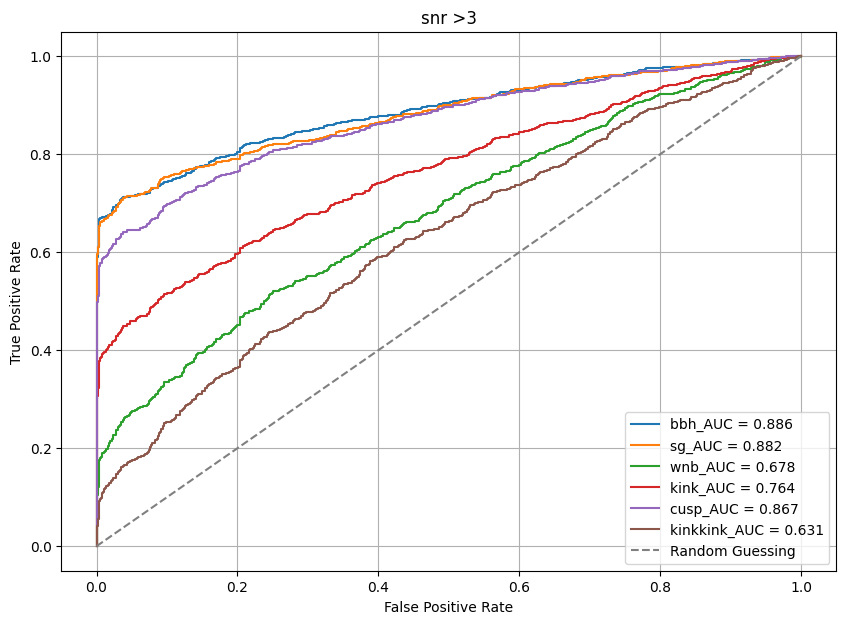


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-28.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


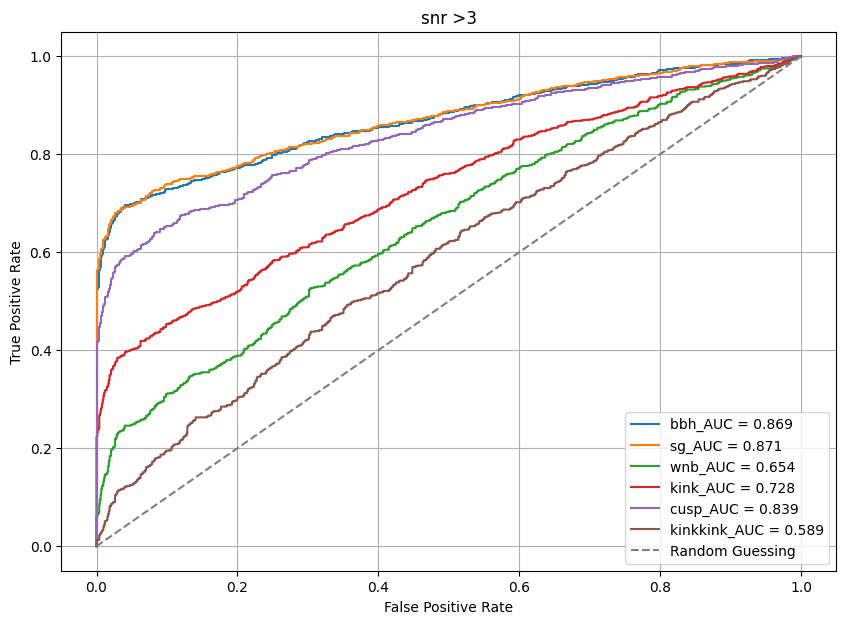


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-29.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


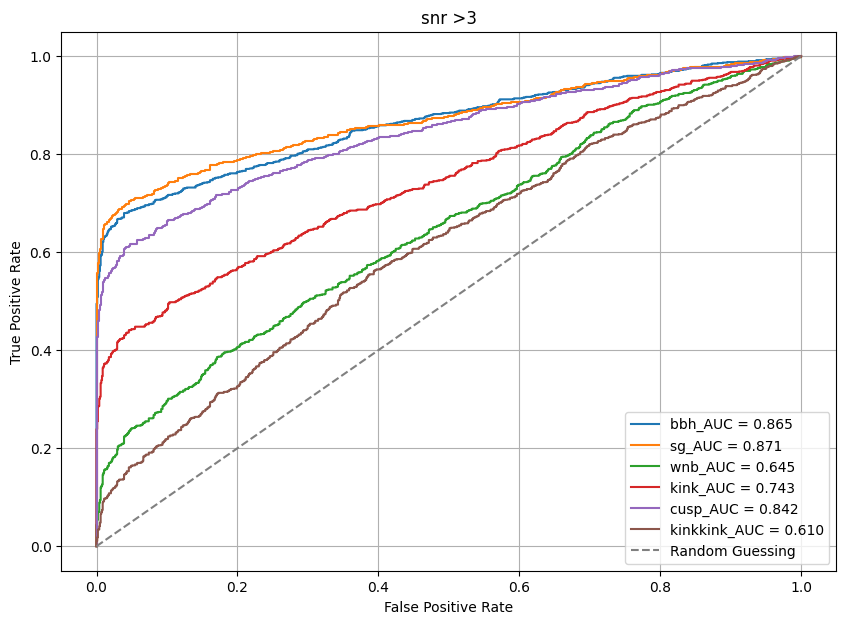


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-30.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


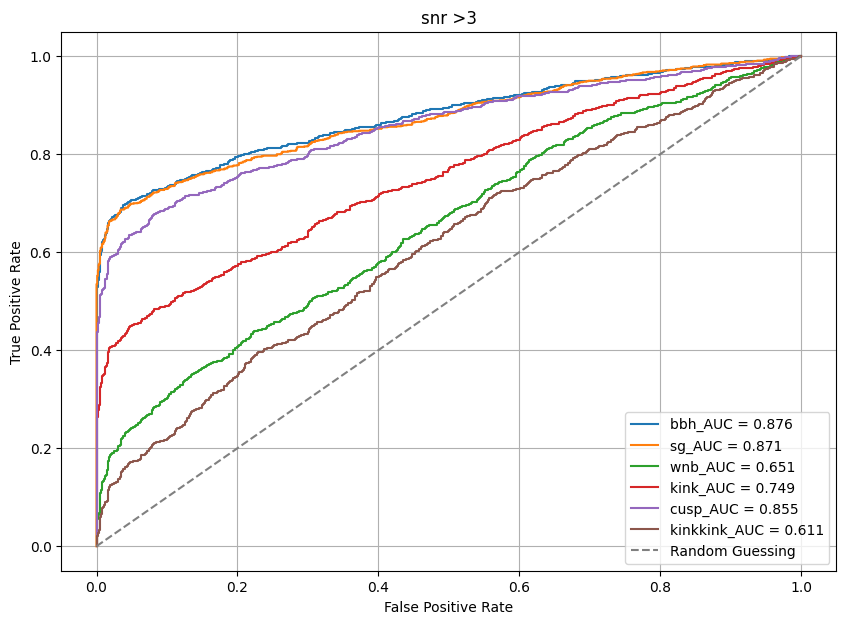


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-31.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


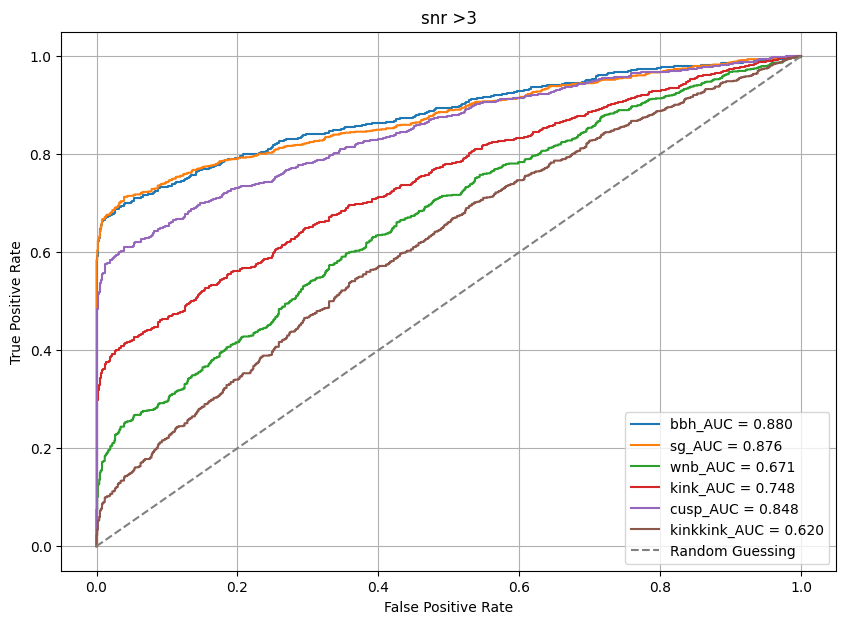


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-32.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


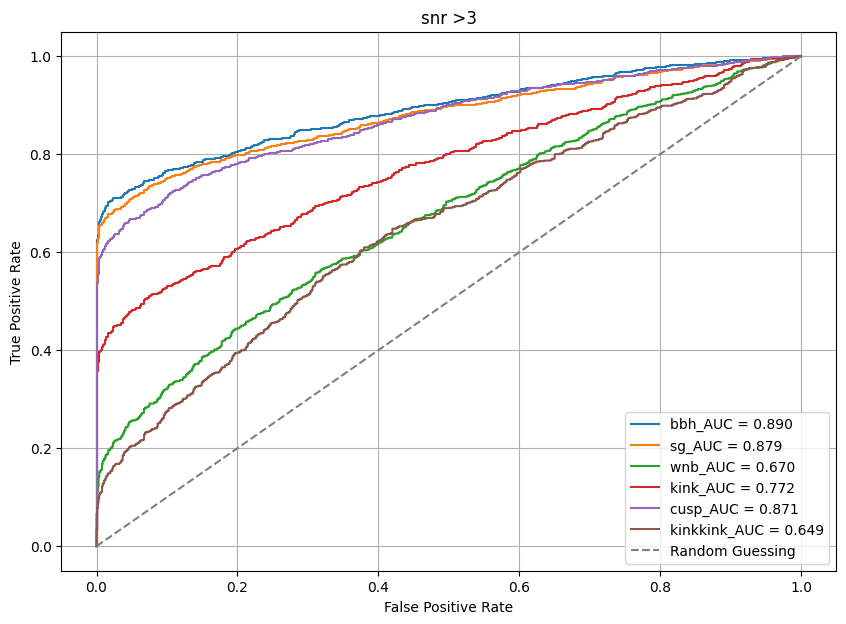


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-33.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


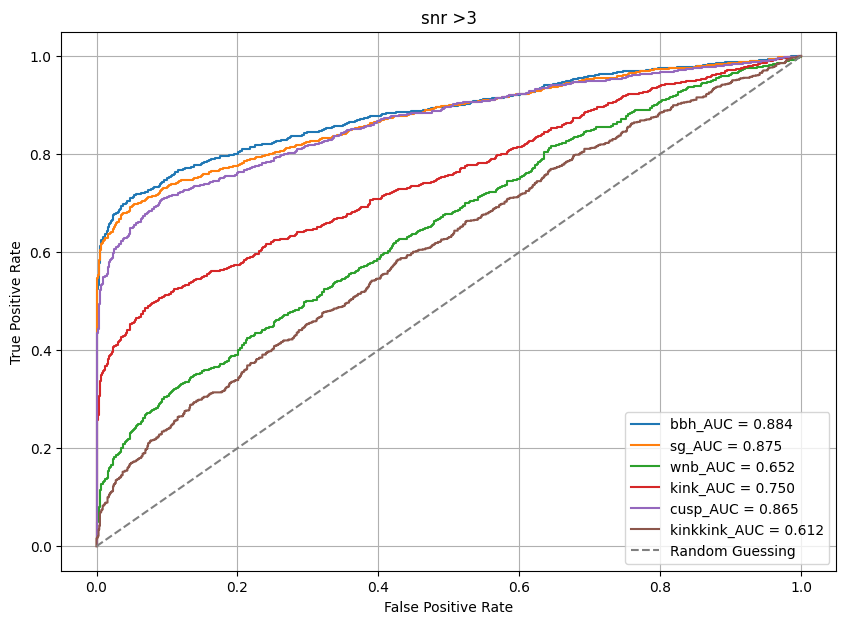


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-34.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


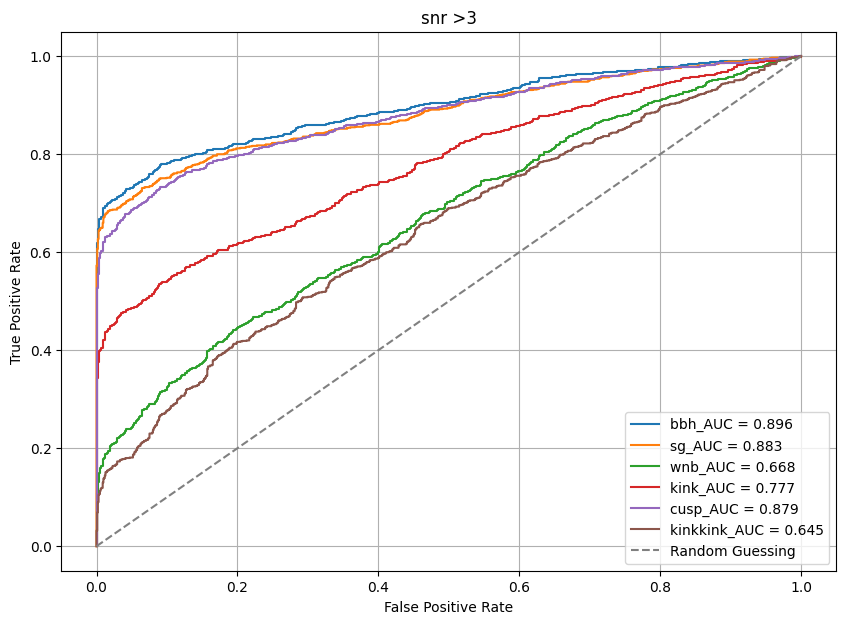


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-35.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


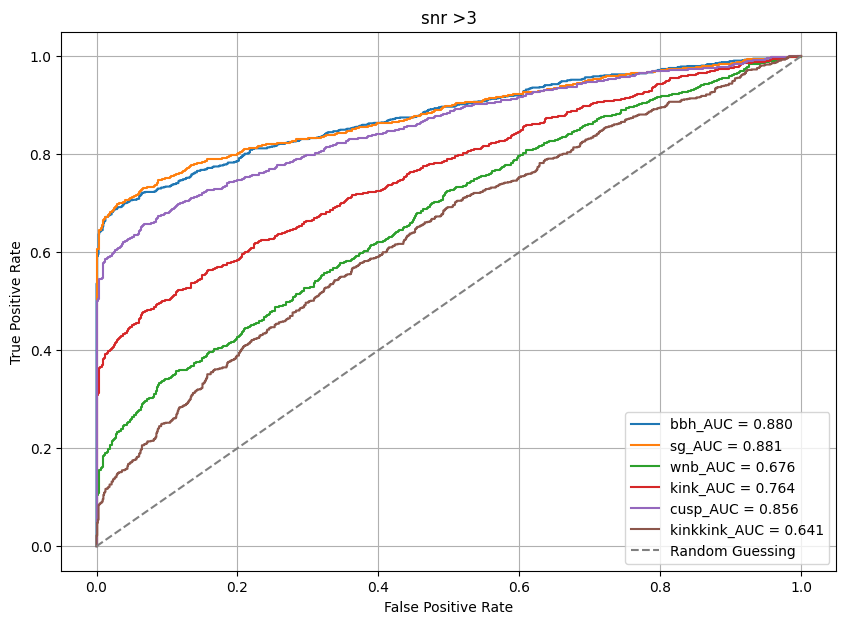


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-36.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


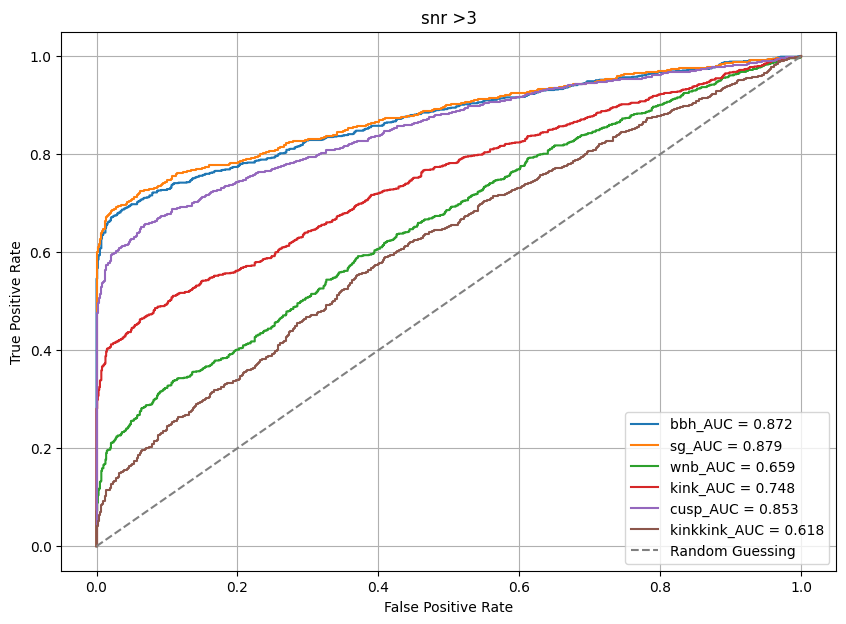


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-37.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


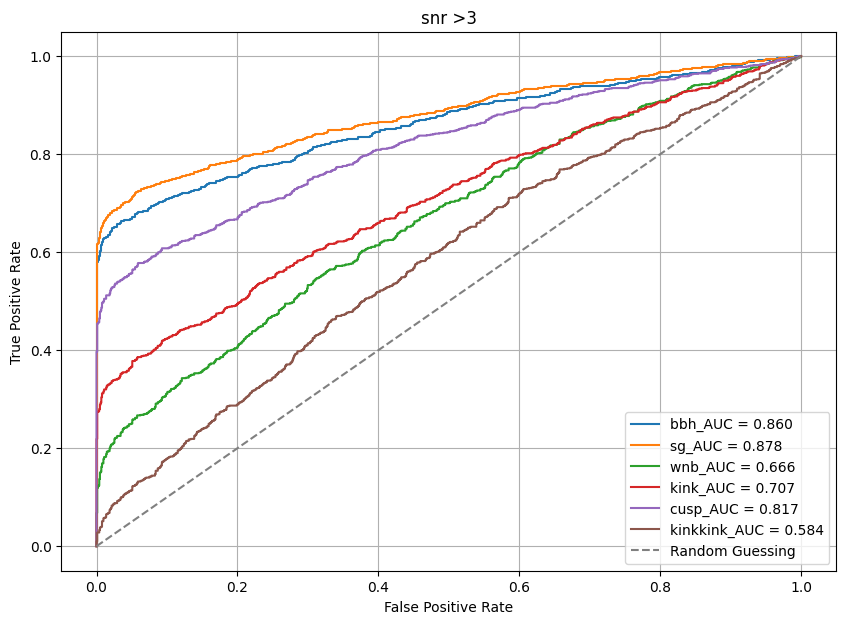


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-38.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


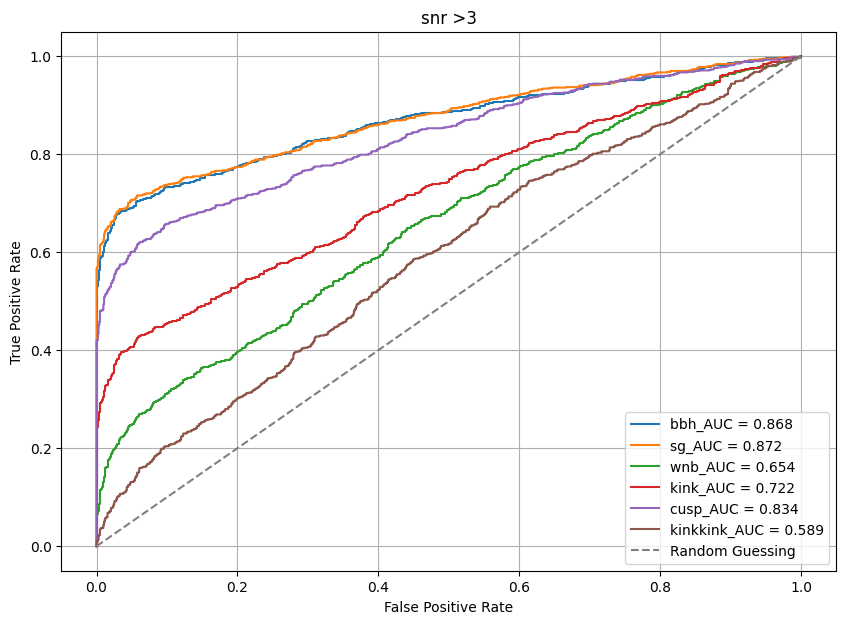


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-39.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


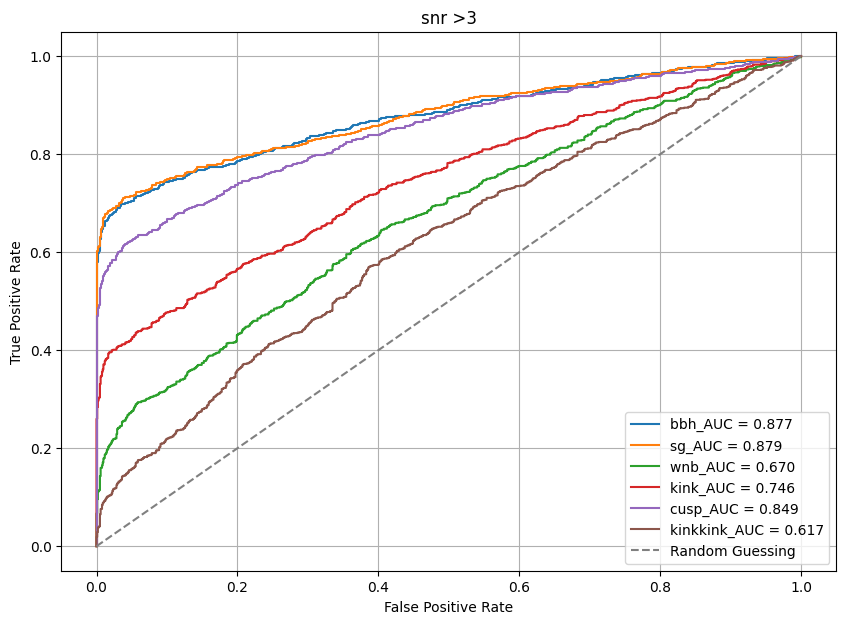


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-40.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


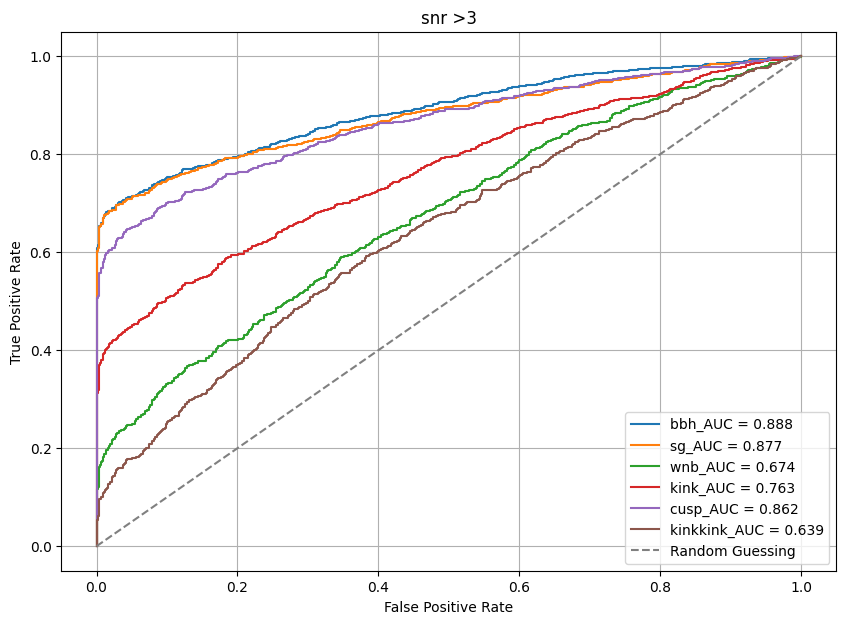


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-41.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


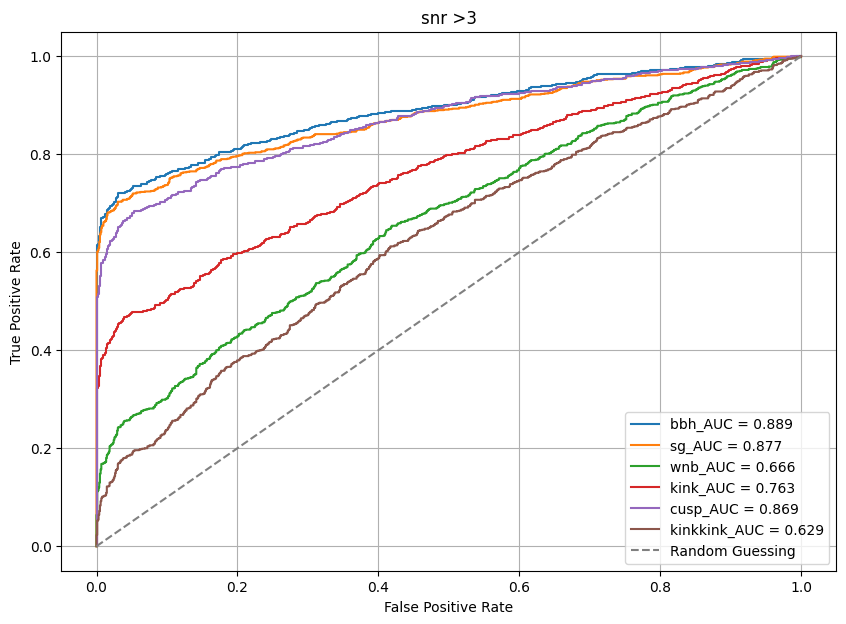


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-42.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


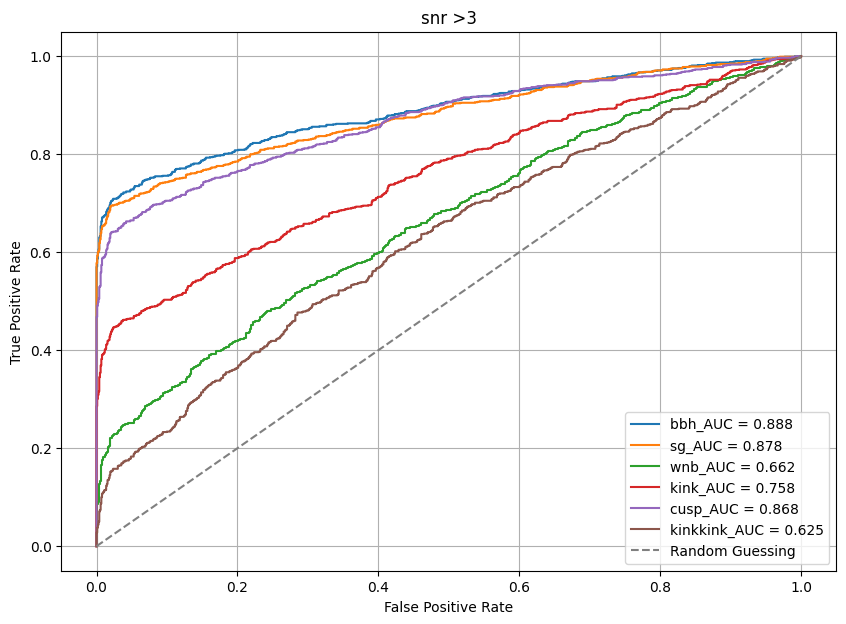


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-43.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


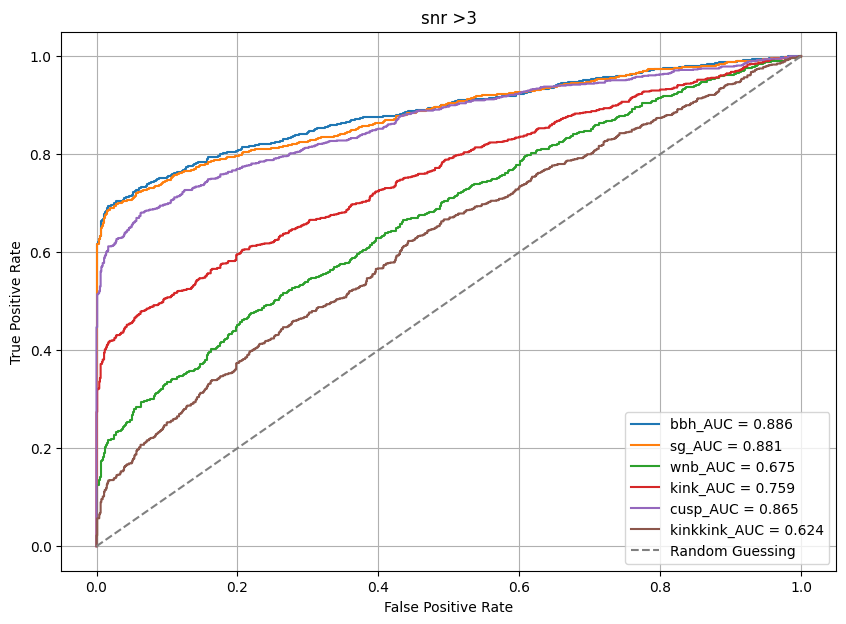


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-44.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


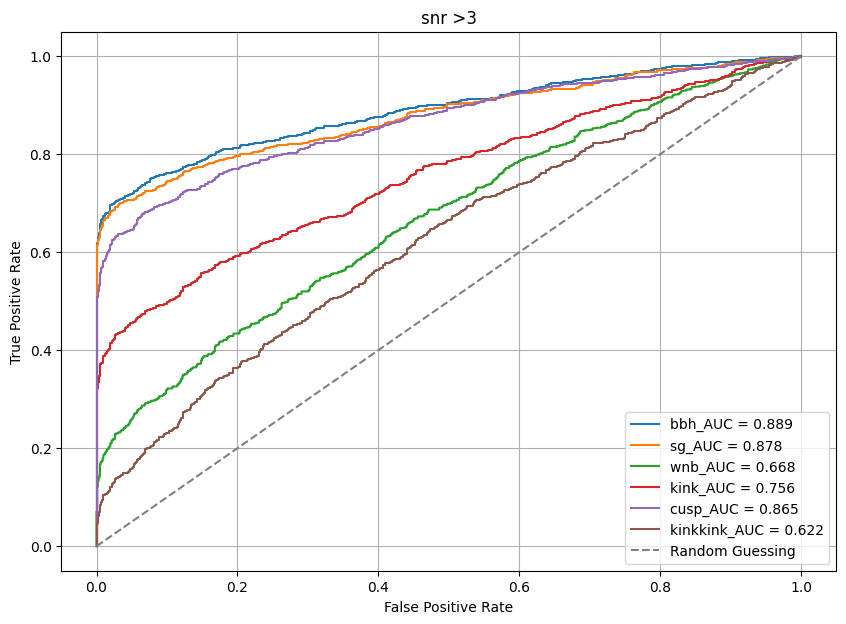


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-45.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


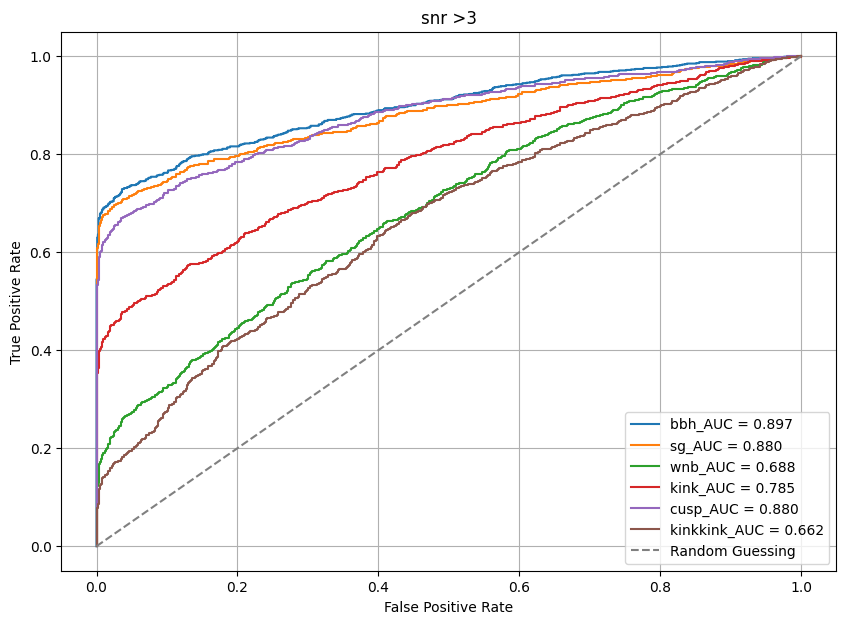


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-46.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


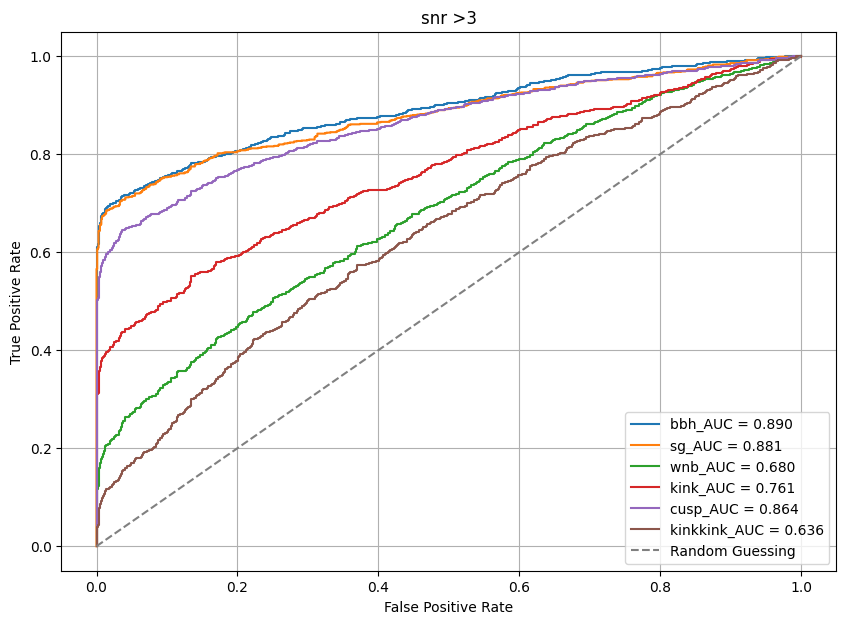


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-47.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


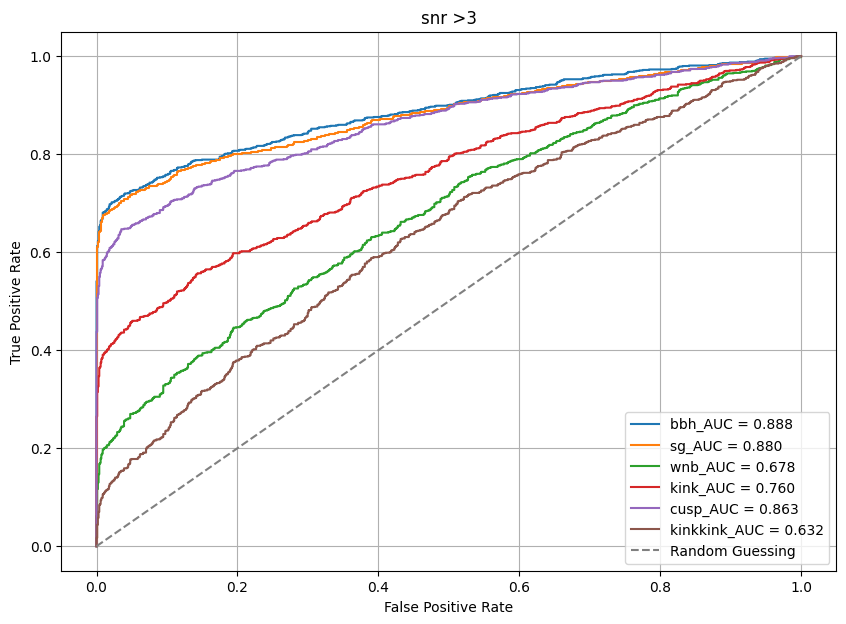


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-48.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


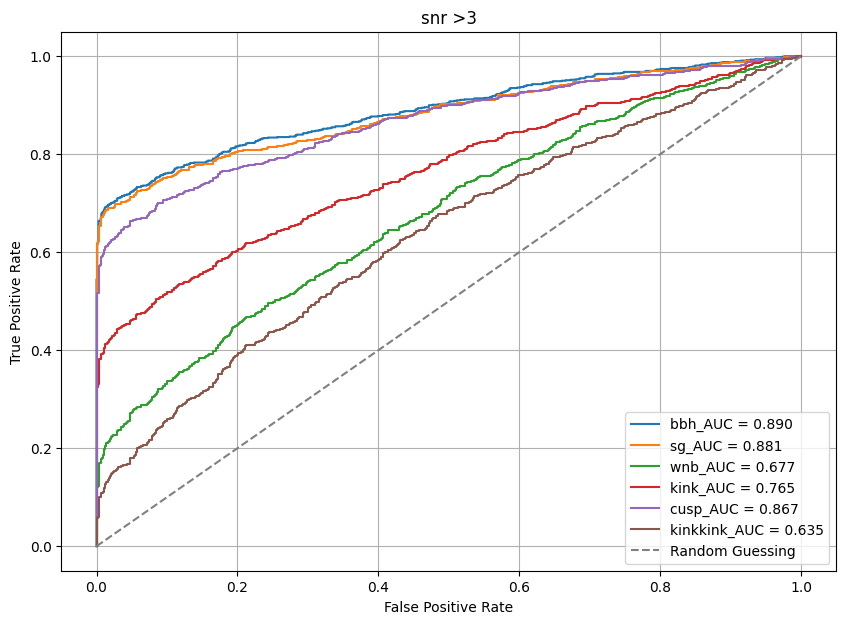


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-49.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


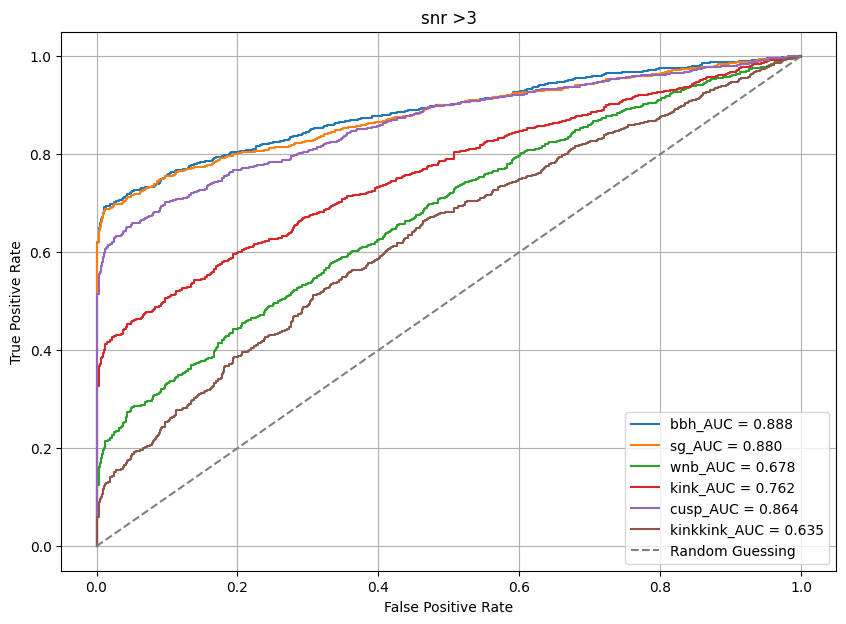


Evaluating model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-50.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


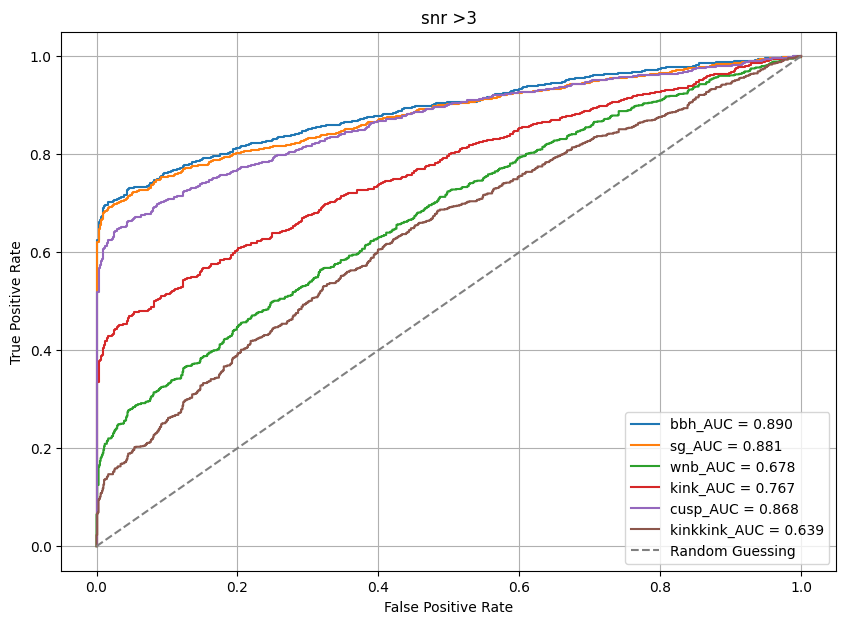


Top models by mean AUC:
model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-45.keras: Mean AUC = 0.7987
model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-23.keras: Mean AUC = 0.7975
model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-34.keras: Mean AUC = 0.7913
model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-32.keras: Mean AUC = 0.7885
model_batch_size-128_dropout-0.1_epochs-50_f1-8_f2-16_f3-32_f4-16_f5-32_f6-16_f7-3_k1-3_k2-5_k3-16_k4-32_k5-4_k6-3_k7-2_lr-0.001_s1-2_s2-2_s3-1_s4-2_s5-2_s6-2_s7-2_epoch-24.keras: Mea

In [114]:
# Path where your models are saved

model_dir = '/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save'
model_files = sorted([f for f in os.listdir(model_dir) if f.endswith('.keras')])

# Test data
auc_results = []

for model_file in model_files:
    print(f"\nEvaluating {model_file}...")
    model = tf.keras.models.load_model(os.path.join(model_dir, model_file))

    bbh_auc, sglf_auc, WNb_auc, kinks_auc, kinkkink_auc, cusps_auc = eval(model, background_test_normed, BBH_normed, SG_normed, WNB_normed, Kink_normed, Cusp_normed, KinkKink_normed)
    auc_list = [bbh_auc, sglf_auc, WNb_auc, kinks_auc, kinkkink_auc, cusps_auc]

    mean_auc = np.mean(auc_list)
    auc_results.append((model_file, mean_auc))

# Sort by mean AUC
sorted_results = sorted(auc_results, key=lambda x: x[1], reverse=True)

print("\nTop models by mean AUC:")
for fname, mean in sorted_results:
    print(f"{fname}: Mean AUC = {mean:.4f}")


In [115]:
for file in glob.glob(os.path.join(model_dir, '*')):
    if os.path.isfile(file):
        os.remove(file)
